In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

from game import *
from random import randint
import networkx as nx
import random

In [2]:
rules = Rules()
rules.nb_max_step = 100
rules.nb_players = 10

game1 = Game()
game1.rules = rules

player1 = Player()
player1.rules = rules
player1.type = EntityType.competitive_player

game1.add_player(player1)

game1.initialize_graph()

In [3]:
random_g = nx.random_graphs.erdos_renyi_graph(10, .3)

In [46]:
#### we want an approximation of betweenness centrality.

def getVertexDiameter(G):
    """
    This is guaranteed to be between VD(G) and 2*VD(G)
    """
    v = random.choice(G.nodes())
    paths = nx.single_source_shortest_path_length(G, v)
    # y take VD(G) to be the sum of the lengths of the two shortest paths with maximum size
    return sum(sorted(paths.values())[-3:-1])

def getSampleSize(VD, eps=.05, delta=.05, c=.5):
    """
    With probability at least 1 − δ, all the approximations computed by the algorithm are within ε
    from their real value
    https://pdfs.semanticscholar.org/213c/7f8e9a8a046020ebfa2a7aaa194b3c05a87a.pdf
    
    By default, this returns sample size needed for 5% error with at least 95% probability
    """
    r = None
    while r is None:
        try:
            r = (c / eps**2) * (np.floor(np.log2(VD - 2)) + np.log(1/delta))
        except:
            pass
    return r

def sampleUniformVertexPair(G):
    """
    Returns a random pair of nodes (no self-loops)
    """
    return np.random.choice(G.nodes(), 2, replace=False)

def computeAllShortestPaths(G, u, v):
    """
    Returns a list of lists (each sublist is a shortest path from u to v)
    """
    try:
        S = list(nx.all_shortest_paths(G,source=u,target=v))
    except:
        S = {}
    return S


def getShortestSubPaths(paths, t):
    return [path[:-1] for path in paths if t in path]
    

def pathCount(paths, t):
    return len([path for path in paths if t in path])

def approximate_betweenness_centrality(G, eps=.05, delta=.05, c=.5):
    """
    Computes the approximate betweenness centrality for the nodes in graph G
    within epsilon error with probability at least 1 - δ.
    https://pdfs.semanticscholar.org/213c/7f8e9a8a046020ebfa2a7aaa194b3c05a87a.pdf
    
    Fast Approximation of Betweenness Centrality through Sampling,
    Matteo Riondato and Evgenios M. Kornaropoulos
    """
    b = dict.fromkeys(G, 0.0)  # b[v]=0 for v in G
    # approximate ~ guaranteed VD <= approx <= 2*VD
    VD = getVertexDiameter(G)
    r = None
    while r is None:
        # if VD <= 2, there are dragons
        try:
            r = int(getSampleSize(VD, eps=eps, delta=delta, c=1))
        except:
            pass
    for i in range(r):
        u, v = sampleUniformVertexPair(G)
        S = computeAllShortestPaths(G, u, v)
        if S:
            # Random path sampling and estimation update
            t = v
            while t != u:
                z_candidates = []
                S_t = getShortestSubPaths(S, t)
                sigma_ut = len(S_t)
                z_probs = []
                for path in S_t:
                    # add immediate predecessors to be candidates for z
                    predecessor = path[-1]
                    z_candidates.append(predecessor)
                    # the number of shortest paths from u to candidate z
                    z_probs.append(pathCount(S_t, predecessor) / sigma_ut)
                # normalize probability
                z_probs = z_probs / np.sum(z_probs)
                # choose a z with weighted probability
                z = np.random.choice(z_candidates, 1, p=z_probs)[0]
                if z != u:
                    # if we haven't backed up all the way, update b(z)
                    b[z] += 1 / r
                t = z
                S = S_t
    return b

In [68]:
random_g = nx.random_graphs.erdos_renyi_graph(100, .5)
VD = getVertexDiameter(random_g)
r = getSampleSize(VD)
r

799.14645471079803

In [69]:
be = nx.betweenness_centrality(random_g)

In [70]:
ba = approximate_betweenness_centrality(random_g, eps=.1, delta=.05, c=.5)

In [71]:
diff = np.array(list(be.values())) - np.array(list(ba.values()))

In [74]:
diff.mean(), diff.std()

(-0.00011609109353470302, 0.003299798950520948)

In [6]:
random_g = nx.random_graphs.erdos_renyi_graph(10, .5)

In [7]:
%timeit nx.betweenness_centrality(random_g)

1000 loops, best of 3: 1.25 ms per loop


In [8]:
%timeit approximate_betweenness_centrality(random_g, eps=.2, delta=.1, c=.5)

10 loops, best of 3: 73 ms per loop


In [25]:
# 10, 20, 50, 100, 500
exact = [.000925, .00467, .047, .344, 49.5, 273]
approx = [.220, .248, .848, 1.41, 23.5, 128]
nodes = [10, 20, 50, 100, 500, 1000]

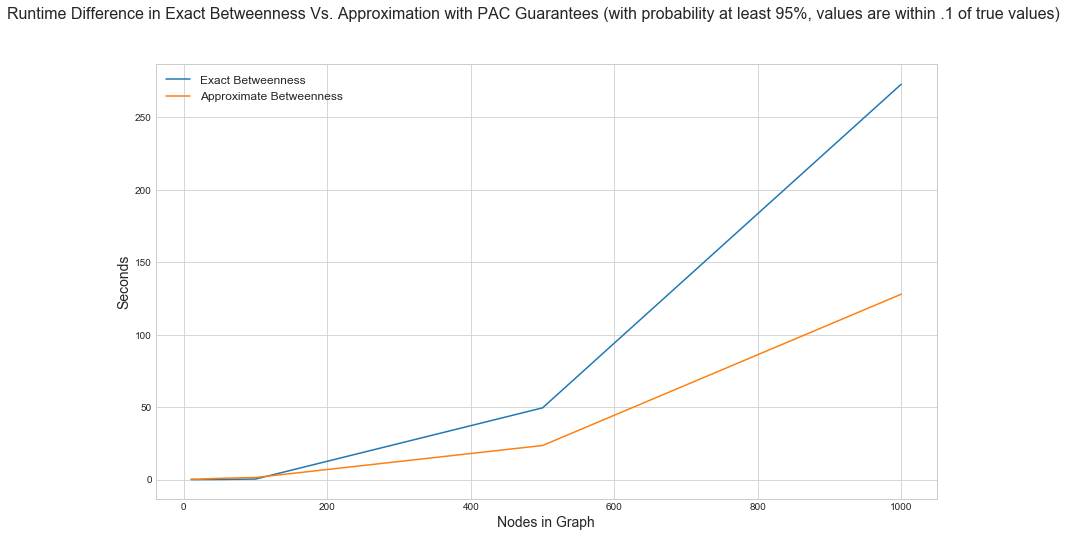

In [27]:
plt.style.use("seaborn-whitegrid")
fig, ax = plt.subplots()
fig.set_size_inches(14, 8)
plt.plot(nodes, exact,label="Exact Betweenness")
plt.plot(nodes, approx, label="Approximate Betweenness")
plt.legend(fontsize=12)
plt.xlabel("Nodes in Graph", fontsize=14)
plt.ylabel("Seconds", fontsize=14)
plt.suptitle("Runtime Difference in Exact Betweenness Vs. Approximation with " + 
             "PAC Guarantees (with probability at least 95%, values are within .1 of true values)", fontsize=16)

In [63]:
def betweenness_centrality(G, k=None, normalized=True,
                           seed=None):
    betweenness = dict.fromkeys(G, 0.0)  # b[v]=0 for v in G
    if k is None:
        nodes = G
    else:
        random.seed(seed)
        nodes = random.sample(G.nodes(), k)
    for s in nodes:
        # single source shortest paths
        S, P, sigma = _single_source_shortest_path_basic(G, s)
        betweenness = _accumulate_basic(betweenness, S, P, sigma, s)
    # rescaling
    betweenness = _rescale(betweenness, len(G),
                           normalized=normalized,
                           directed=G.is_directed(),
                           k=k)
    return betweenness

def _accumulate_basic(betweenness, S, P, sigma, s):
    delta = dict.fromkeys(S, 0)
    while S:
        w = S.pop()
        coeff = (1.0 + delta[w]) / sigma[w]
        for v in P[w]:
            delta[v] += sigma[v] * coeff
        if w != s:
            betweenness[w] += delta[w]
    return betweenness

def _rescale(betweenness, n, normalized, directed=False, k=None):
    if normalized is True:
        if n <= 2:
            scale = None  # no normalization b=0 for all nodes
        else:
            scale = 1.0 / ((n - 1) * (n - 2))
    else:  # rescale by 2 for undirected graphs
        if not directed:
            scale = 1.0 / 2.0
        else:
            scale = None
    if scale is not None:
        if k is not None:
            scale = scale * n / k
        for v in betweenness:
            betweenness[v] *= scale
    return betweenness

def _single_source_shortest_path_basic(G, s):
    S = []
    P = {}
    for v in G:
        P[v] = []
    sigma = dict.fromkeys(G, 0.0)    # sigma[v]=0 for v in G
    D = {}
    sigma[s] = 1.0
    D[s] = 0
    Q = [s]
    while Q:   # use BFS to find shortest paths
        v = Q.pop(0)
        S.append(v)
        Dv = D[v]
        sigmav = sigma[v]
        for w in G[v]:
            if w not in D:
                Q.append(w)
                D[w] = Dv + 1
            if D[w] == Dv + 1:   # this is a shortest path, count paths
                sigma[w] += sigmav
                P[w].append(v)  # predecessors
    return S, P, sigma

In [40]:
betweenness_centrality(random_g)

{0: 0.009259259259259259,
 1: 0.09259259259259257,
 2: 0.09259259259259257,
 3: 0.18055555555555555,
 4: 0.06944444444444445,
 5: 0.018518518518518517,
 6: 0.009259259259259259,
 7: 0.013888888888888888,
 8: 0.04166666666666666,
 9: 0.0}

In [28]:
nx.betweenness_centrality(random_g)

{0: 0.009259259259259259,
 1: 0.09259259259259257,
 2: 0.09259259259259257,
 3: 0.18055555555555555,
 4: 0.06944444444444445,
 5: 0.018518518518518517,
 6: 0.009259259259259259,
 7: 0.013888888888888888,
 8: 0.04166666666666666,
 9: 0.0}

In [31]:
%timeit betweenness_centrality(random_g)

1000 loops, best of 3: 861 µs per loop


In [32]:
%timeit nx.betweenness_centrality(random_g)

1000 loops, best of 3: 797 µs per loop


In [16]:
%timeit nx.betweenness_centrality(random_g, k = 1)

1000 loops, best of 3: 618 µs per loop


In [299]:
def get_game_graph(game):
    return np.float32(nx.adjacency_matrix(game.graph).todense())

def expand_dims(x):
    y = x[np.newaxis,:]
    y = np.expand_dims(y, axis=3)
    return np.float32(y)

x = get_game_graph(game1)

In [300]:
x.shape

(10, 10)

In [301]:
def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

def conv2d(x, W):
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

In [302]:
dim = rules.nb_players

In [320]:
#tf.reset_default_graph()
graph = tf.Graph()
with graph.as_default():
    #These lines establish the feed-forward part of the network used to choose actions
    x = tf.placeholder(tf.float32, shape=[1, dim**2])
    #x_image = tf.reshape(x, [-1,dim,dim,1])

    #W = tf.Variable(tf.random_uniform([400,10],0,0.01))
    #b = tf.Variable(tf.zeros([10]))

    #W_conv1 = weight_variable([3, 3, 1, 32])
    #b_conv1 = bias_variable([32])
    #h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
    #h_pool1 = max_pool_2x2(h_conv1)
    W_fc1 = weight_variable([dim**2, 128])
    b_fc1 = bias_variable([128])

    #h_pool1_flat = tf.reshape(h_pool1, [-1, int(dim/2) * int(dim/2) * 32])
    h_fc1 = tf.nn.relu(tf.matmul(x, W_fc1) + b_fc1)
    W_fc2 = weight_variable([128, 64])
    b_fc2 = bias_variable([64])
    h_fc2 = tf.nn.relu(tf.matmul(h_fc1, W_fc2) + b_fc2)
    keep_prob = tf.placeholder(tf.float32)
    h_fc2_drop = tf.nn.dropout(h_fc2, keep_prob)
    W_fc3 = weight_variable([64, dim])
    b_fc3 = bias_variable([dim])
    Qout = tf.matmul(h_fc2_drop, W_fc3) + b_fc3

    #Qout = tf.matmul(x, W) + b
    predict = tf.argmax(Qout,1)

    #Below we obtain the loss by taking the sum of squares difference between the target and prediction Q values.
    nextQ = tf.placeholder(shape=[1,dim],dtype=tf.float32)
    loss = tf.reduce_sum(tf.square(nextQ - Qout))
    trainer = tf.train.AdamOptimizer(learning_rate=0.001)
    updateModel = trainer.minimize(loss)
    init = tf.global_variables_initializer()

In [325]:
# Set learning parameters
y = .99
e = 0.1
num_episodes = 500
#create lists to contain total rewards and steps per episode
jList = []
rList = []
winList = []
with tf.Session(graph=graph) as sess:
    sess.run(init)
    for i in range(num_episodes):
        #Reset environment and get first new observation
        if i % 10 == 0:
            print("Episode {}".format(i))
        rules = Rules()
        rules.nb_max_step = 100
        rules.nb_players = dim
        game1 = Game()
        game1.rules = rules
        player1 = Player()
        player1.name = "RL"
        player1.rules = rules
        player1.type = EntityType.competitive_player
        game1.add_player(player1)
        
        
        player2 = Player()
        player2.rules = rules
        player2.name = "Heuristic"
        player2.type = EntityType.competitive_player
        strategy_builder = StrategyBuilder()
        player2.strategy = strategy_builder.get_random_egoist_strategy()
        game1.add_player(player2)
        
        game1.initialize_graph()
        
        s = get_game_graph(game1).flatten()
        
        rAll = 0
        previous_centrality = 0
        d = False
        j = 0
        win = 0
        #The Q-Network
        while j < rules.nb_max_step:
            j+=1
            #Choose an action by greedily (with e chance of random action) from the Q-network
            a, allQ = sess.run([predict,Qout],feed_dict={x:s.astype(np.float32), keep_prob:.7})
            if np.random.rand(1) < e:
                a[0] = np.random.randint(dim)
            #Get new state and reward from environment
            action = None
            if a[0] is not 0:
                action = [(0, a[0])]
            actions = list(game1.get_actions())
            #action.extend(actions)
            game1.play_round(actions=action)
            s1 = get_game_graph(game1).flatten()
            centralities = nx.betweenness_centrality(game1.graph)
            centrality = centralities[0]
            if centrality == previous_centrality:
                r = 0
            elif centrality > previous_centrality:
                r = 1
            else:
                r = -1
            #print(centrality, previous_centrality, r)
            #Obtain the Q' values by feeding the new state through our network
            Q1 = sess.run(Qout,feed_dict={x:s1, keep_prob:.7})
            #Obtain maxQ' and set our target value for chosen action.
            maxQ1 = np.max(Q1)
            targetQ = allQ
            targetQ[0,a[0]] = r + y*maxQ1
            #Train our network using target and predicted Q values
            updateModel.run(feed_dict={x:s,nextQ:targetQ, keep_prob:.7})
            rAll += r
            s = s1
            previous_centrality = centrality
            
            opponent_centrality = centralities[1]
            if centrality > opponent_centrality:
                win += 1
            if centrality == 1 and j > 20:
                #Reduce chance of random action as we train the model.
                e = 1./((i/50) + 10)
                break
        winList.append(win)
        jList.append(j)
        rList.append(rAll)
rList = np.array(rList)
print("Percent of succesful episodes: " + str(np.sum(rList)/num_episodes) + "%")

Episode 0
Episode 10
Episode 20
Episode 30
Episode 40
Episode 50
Episode 60
Episode 70
Episode 80
Episode 90
Episode 100
Episode 110
Episode 120
Episode 130
Episode 140
Episode 150
Episode 160
Episode 170
Episode 180
Episode 190
Episode 200
Episode 210
Episode 220
Episode 230
Episode 240
Episode 250
Episode 260
Episode 270
Episode 280
Episode 290
Episode 300
Episode 310
Episode 320
Episode 330
Episode 340
Episode 350
Episode 360
Episode 370
Episode 380
Episode 390
Episode 400
Episode 410
Episode 420
Episode 430
Episode 440
Episode 450
Episode 460
Episode 470
Episode 480
Episode 490
Percent of succesful episodes: 6.344%


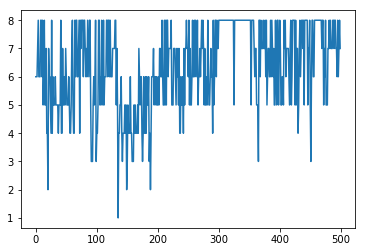

In [326]:
plt.plot(rList)

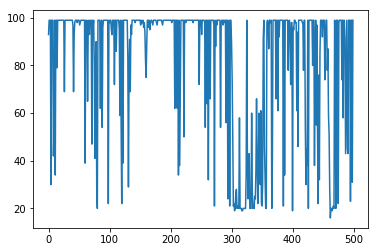

In [327]:
plt.plot(winList)

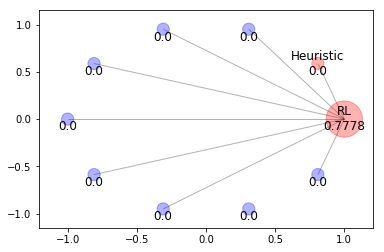

In [328]:
plotter = Plotter()
plotter.plot_state(game1)

In [1]:
"""
A bare bones examples of optimizing a black-box function (f) using
Natural Evolution Strategies (NES), where the parameter distribution is a 
gaussian of fixed standard deviation.
"""

import numpy as np
np.random.seed(0)

# the function we want to optimize
def f(w):
  # here we would normally:
  # ... 1) create a neural network with weights w
  # ... 2) run the neural network on the environment for some time
  # ... 3) sum up and return the total reward

  # but for the purposes of an example, lets try to minimize
  # the L2 distance to a specific solution vector. So the highest reward
  # we can achieve is 0, when the vector w is exactly equal to solution
  reward = -np.sum(np.square(solution - w))
  return reward

# hyperparameters
npop = 50 # population size
sigma = 0.1 # noise standard deviation
alpha = 0.001 # learning rate

# start the optimization
solution = np.array([0.5, 0.1, -0.3])
w = np.random.randn(3) # our initial guess is random
for i in range(300):

  # print current fitness of the most likely parameter setting
  if i % 20 == 0:
    print('iter %d. w: %s, solution: %s, reward: %f' % 
          (i, str(w), str(solution), f(w)))

  # initialize memory for a population of w's, and their rewards
  N = np.random.randn(npop, 3) # samples from a normal distribution N(0,1)
  R = np.zeros(npop)
  for j in range(npop):
    w_try = w + sigma*N[j] # jitter w using gaussian of sigma 0.1
    R[j] = f(w_try) # evaluate the jittered version

  # standardize the rewards to have a gaussian distribution
  A = (R - np.mean(R)) / np.std(R)
  # perform the parameter update. The matrix multiply below
  # is just an efficient way to sum up all the rows of the noise matrix N,
  # where each row N[j] is weighted by A[j]
  w = w + alpha/(npop*sigma) * np.dot(N.T, A)

iter 0. w: [ 1.76405235  0.40015721  0.97873798], solution: [ 0.5  0.1 -0.3], reward: -3.323094
iter 20. w: [ 1.63796944  0.36987244  0.84497941], solution: [ 0.5  0.1 -0.3], reward: -2.678783
iter 40. w: [ 1.50042904  0.33577052  0.70329169], solution: [ 0.5  0.1 -0.3], reward: -2.063040
iter 60. w: [ 1.36438269  0.29247833  0.56990397], solution: [ 0.5  0.1 -0.3], reward: -1.540938
iter 80. w: [ 1.2257328   0.25622233  0.43607161], solution: [ 0.5  0.1 -0.3], reward: -1.092895
iter 100. w: [ 1.08819889  0.22827364  0.30415088], solution: [ 0.5  0.1 -0.3], reward: -0.727430
iter 120. w: [ 0.95675286  0.19282042  0.16682465], solution: [ 0.5  0.1 -0.3], reward: -0.435164
iter 140. w: [ 0.82214521  0.16161165  0.03600742], solution: [ 0.5  0.1 -0.3], reward: -0.220475
iter 160. w: [ 0.70282088  0.12935569 -0.09779598], solution: [ 0.5  0.1 -0.3], reward: -0.082885
iter 180. w: [ 0.58380424  0.11579811 -0.21083135], solution: [ 0.5  0.1 -0.3], reward: -0.015224
iter 200. w: [ 0.52089064 